##### Welcome

In [97]:
print("-"*40)
print("Welcome to the image convolver thing!\nPlease ensure that the image is present in the same directory as this program, and that the following dependencies are installed:\n\t- NumPy\n\t- Pillow\n\t- PyTorch\n\t- MatPlotLib\n")

----------------------------------------
Welcome to the image convolver thing!
Please ensure that the image is present in the same directory as this program, and that the following dependencies are installed:
	- NumPy
	- Pillow
	- PyTorch
	- MatPlotLib



##### Import Packages

In [98]:
print("Checking dependencies...")
pos = 0
dependency_list = ["Pillow", "NumPy", "PyTorch", "MatPlotLib"]
try:
    from PIL import Image
    pos +=1
    import numpy as np
    pos +=1
    import torch
    from torch import nn
    pos +=1
    import matplotlib.pyplot as plt
    pos +=1
    import sys
    import math
except:
    sys.exit(f"Dependency error for {dependency_list[pos]}")

print("Dependency checks complete.")

Checking dependencies...
Dependency checks complete.


In [99]:
debug_mode = 2

if (debug_mode==1):
    image_name = "testfile.jpg"
elif (debug_mode==2):
    image_name = "city.png"
else:
    image_name = input("Enter the name of the file (including the file extension, e.g. example.png): ")

'''
Goals:
1. mean blur ✓
2. gaussian blur ✓
3. test filter ✓
3. edge detection: sobel + canny
4. foreground/background blur and detection
'''

'\nGoals:\n1. mean blur ✓\n2. gaussian blur ✓\n3. bokeh filter\n3. edge detection: sobel + canny\n4. foreground/background blur and detection\n'

##### Open image

In [100]:
image_file = Image.open(f"./{image_name}")
image_array = np.asarray(image_file)
print(image_array.shape)
# i = Image.fromarray(image_array)
# i.save("copy.jpg")

(2160, 3840, 4)


##### Define Cross Correlation, i.e. Convolution function

In [101]:
def corr2d(X, K):
    """
    Compute single channel 2D cross-correlation.
    X: Input array, i.e. channel
    K: Kernel
    Y: Output array, i.e. feature map
    Credit: Dive into Deep Learning, A. Zhang et al
    """

    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    count = 0
    total_count=Y.shape[0]*Y.shape[1]
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            count += 1
            sys.stdout.write('\r')
            sys.stdout.write("%d%" % (count/total_count,))
            sys.stdout.flush()
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    
    return Y

In [102]:
def corr2d_separable(X, k):
    '''
    Compute single channel 2D cross-correlation, but significantly faster by using separable kernels.
    Performs two linear passes with the kernel vector, one with the linear kernel, followed by one with its transpose.
    X: Input array, i.e. channel
    k: Kernel vector
    Y: Output array, i.e. feature map
    '''
    k = k.reshape(-1,1)
    first_pass_featuremap = corr2d(X,k)
    Y = corr2d(first_pass_featuremap,k.T)
    
    return second_pass_featuremap  

In [103]:
def corr2d_separable_multichannel(X, k):
    '''
    Compute multichannel channel 2D cross-correlation using separable kernels.
    X: Input array, i.e. channels
    k: Kernel vector
    Y: Output array, i.e. feature map
    '''
    # Future: Implement true multichannel support, where num_channels is an input
    R = X[:,:,0]
    G = X[:,:,1]
    B = X[:,:,2]
    k = k.reshape(-1,1)
    
    print("Performing convolution on R Channel")
    first_pass_featuremap_R = corr2d(R,k)
    R_featuremap = corr2d(first_pass_featuremap_R,k.T)

    print("Performing convolution on G Channel")
    first_pass_featuremap_G = corr2d(G,k)
    G_featuremap = corr2d(first_pass_featuremap_G,k.T)

    print("Performing convolution on B Channel")
    first_pass_featuremap_B = corr2d(B,k)
    B_featuremap = corr2d(first_pass_featuremap_B,k.T)

    print("Convolutions complete!")
    
    Y = np.empty(R_featuremap.shape + (3,))
    Y[:,:,0] = R_featuremap
    Y[:,:,1] = G_featuremap
    Y[:,:,2] = B_featuremap
    return Y 

##### Define filters

In [104]:
def mean_blur(image_array, kernel_size=3, save=False):
    '''
    Implements mean blur. 
    Essentially, each new pixel is just the mean of the color values 
    '''

    kernel = np.ones(kernel_size)
    
    featuremap = corr2d_separable_multichannel(image_array, kernel)
    featuremap = featuremap/(kernel_size**2)
    print(f"Featuremap of shape {featuremap.shape} generated!")

    return featuremap

In [105]:
def show_image(featuremap, save=False, suffix="modified"):
    featuremap *= 255.0/featuremap.max()
    cur_image = Image.fromarray(featuremap.astype(np.uint8)) #future note: PIL will accept <np.uint8> but not just <int>
    cur_image.show()
    
    if (save):
        new_filename = image_name.split(".")[0] + "_" + suffix
        cur_image.save(f"{new_filename}.png")
        print(f"{new_filename}.png saved!")
    return

In [106]:
def normal_value(x, std):
    f = (1/math.sqrt(2*math.pi))*np.exp(-0.5*((x/std)**2))
    return f

In [107]:
def generate_kernel_gaussian_separable(kernel_size=10):
    if (kernel_size==1):
        return np.array([1])
    elif (kernel_size==2):
        return np.array([1,1])

    std = kernel_size
    if (kernel_size%2==0):
        step = std/((std/2)-1)
        kernel = np.arange(-std, step, step)
        kernel = np.append(kernel, -kernel[::-1])
    else:
        step = std/int(std/2)
        kernel = np.arange(-std, step, step)
        kernel = np.append(kernel, -kernel[::-1][1:])

    return kernel, normal_value(kernel, std/3)

Gaussian Demo

[-2.00000000e+01 -1.77777778e+01 -1.55555556e+01 -1.33333333e+01
 -1.11111111e+01 -8.88888889e+00 -6.66666667e+00 -4.44444444e+00
 -2.22222222e+00 -7.10542736e-15  7.10542736e-15  2.22222222e+00
  4.44444444e+00  6.66666667e+00  8.88888889e+00  1.11111111e+01
  1.33333333e+01  1.55555556e+01  1.77777778e+01  2.00000000e+01]


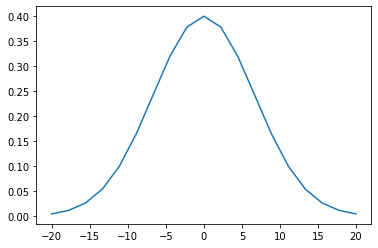

In [108]:
x, y = generate_kernel_gaussian_separable(20)
print(x)
plt.plot(x, y)
plt.show()

In [109]:
def gaussian_blur(image_array, kernel_size=10, save=False):
    '''
    Implements gaussian blur.
    '''

    kernel = generate_kernel_gaussian_separable(kernel_size)[1]
    
    featuremap = corr2d_separable_multichannel(image_array, kernel)
    featuremap = featuremap/np.sum(kernel**2)
    print(f"Featuremap of shape {featuremap.shape} generated!")

    return featuremap

In [110]:
# Y = mean_blur(image_array=image_array, kernel_size=40)

In [111]:
# show_image(Y, True, "mean_blur")

In [112]:
# Y = gaussian_blur(image_array=image_array, kernel_size=40)

In [113]:
# show_image(Y, True, "gaussian_blur")

In [114]:
def calc_circular_dof_filter_components(a, b, A, B, x):
    real_part = np.cos(b*(x**2))*np.exp(-a*(x**2))
    complex_part = np.sin(b*(x**2))*np.exp(-a*(x**2))
    
    return real_part, complex_part

In [115]:
def generate_circular_dof_filter(a, b, A, B, x):
    
    return None

In [116]:
def generate_test_filter_dof(kernel_size, a=16, range_=4):
    if (kernel_size==1):
        return np.array([1])
    elif (kernel_size==2):
        return np.array([1,1])

    limiter = range_/2
    step = range_/(kernel_size-1)
    kernel = np.arange(-limiter, limiter+step, step)
    
    return kernel, np.exp(-(kernel**a))

In [117]:
res = generate_test_filter_dof(40)

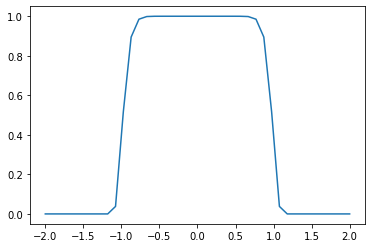

In [118]:
plt.figure()
plt.plot(res[0], res[1])
plt.show()

In [119]:
# print(res[1])
newVect = res[1].reshape(-1,1)
matri_ver = np.matmul(newVect, newVect.T)
matri_ver = matri_ver*255/np.max(matri_ver)
show_image(matri_ver)

In [120]:
def test_filter_dof(image_array, kernel_size=10, save=False):
    '''
    Implements square DOF by exponents.
    '''

    kernel = generate_test_filter_dof(kernel_size)[1]
    
    featuremap = corr2d_separable_multichannel(image_array, kernel)
    featuremap = featuremap/np.sum(kernel**2)
    print(f"Featuremap of shape {featuremap.shape} generated!")

    return featuremap

In [121]:
Y = test_filter_dof(image_array=image_array, kernel_size=200)
show_image(Y, True, "square_blur")

Performing convolution on R Channel
Performing convolution on G Channel
Performing convolution on B Channel
Convolutions complete!
Featuremap of shape (2121, 3801, 3) generated!
city_square_blur.png saved!
